In [1]:
#imports

from pathlib import Path
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas as gp

#read data
df = pd.read_csv(Path.cwd().parents[0] / "CSV" / "Raw"/ "presentation.csv")
df.head()


,long,lat,post_publish_date,hashtags,post_body,emoji
0,-2.115866,53.073712,2017-01-18 12:17:35,"{Brexit,PMQs,immigration}",""".@theresa_may: '""We can still have EU workers...",{}
1,14.380054,35.934249,2017-01-18 12:19:19,"{EU2017MT,migration}",Throwing more money will not solve #migration ...,{}
2,9.818380,46.764999,2017-01-18 12:27:15,"{wef17,TeamRefugees}",Syrian refugee @YusraMardini speaking at a #we...,{}
3,20.834226,39.655955,2017-01-18 12:34:27,{Refugee},#Refugee kids from the accommodation site of V...,{}
4,4.577031,52.294800,2017-01-18 13:07:08,"{Tunisia,migrants,refugees}",I'm afraid @CroissantRouge volunteers in #Tuni...,{}


In [2]:
#clean data

def clean_emoji(x):
    if x == '{}':
        return ''
    else:
        return x[1:-1]

df['emoji'] = df['emoji'].apply(clean_emoji)
df['hashtags'] = df['hashtags'].apply(lambda x:x[1:-1])
df.head()  

,long,lat,post_publish_date,hashtags,post_body,emoji
0,-2.115866,53.073712,2017-01-18 12:17:35,"Brexit,PMQs,immigration",""".@theresa_may: '""We can still have EU workers...",
1,14.380054,35.934249,2017-01-18 12:19:19,"EU2017MT,migration",Throwing more money will not solve #migration ...,
2,9.818380,46.764999,2017-01-18 12:27:15,"wef17,TeamRefugees",Syrian refugee @YusraMardini speaking at a #we...,
3,20.834226,39.655955,2017-01-18 12:34:27,Refugee,#Refugee kids from the accommodation site of V...,
4,4.577031,52.294800,2017-01-18 13:07:08,"Tunisia,migrants,refugees",I'm afraid @CroissantRouge volunteers in #Tuni...,


In [4]:
#change timestamps to datetime format

df['post_publish_date'] = pd.to_datetime(df['post_publish_date'])
df['post_publish_date']

0       2017-01-18 12:17:35
1       2017-01-18 12:19:19
2       2017-01-18 12:27:15
3       2017-01-18 12:34:27
4       2017-01-18 13:07:08
                ...        
73277   2017-01-18 11:05:00
73278   2017-01-18 11:22:18
73279   2017-01-18 11:17:53
73280   2017-01-18 11:30:09
73281   2017-01-18 11:47:23
Name: post_publish_date, Length: 73282, dtype: datetime64[ns]

In [5]:
#count the most common hashtags

results = Counter()
df['hashtags'].str.lower().str.split(',').apply(results.update)
print(results.most_common(5))

[('refugees', 12806), ('muslimban', 7960), ('migration', 6173), ('refugeeswelcome', 6109), ('immigration', 5087)]


In [7]:
gdf =gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.long, df.lat))
gdf.head()

,long,lat,post_publish_date,hashtags,post_body,emoji,geometry
0,-2.115866,53.073712,2017-01-18 12:17:35,"Brexit,PMQs,immigration",""".@theresa_may: '""We can still have EU workers...",,POINT (-2.11587 53.07371)
1,14.380054,35.934249,2017-01-18 12:19:19,"EU2017MT,migration",Throwing more money will not solve #migration ...,,POINT (14.38005 35.93425)
2,9.818380,46.764999,2017-01-18 12:27:15,"wef17,TeamRefugees",Syrian refugee @YusraMardini speaking at a #we...,,POINT (9.81838 46.76500)
3,20.834226,39.655955,2017-01-18 12:34:27,Refugee,#Refugee kids from the accommodation site of V...,,POINT (20.83423 39.65596)
4,4.577031,52.294800,2017-01-18 13:07:08,"Tunisia,migrants,refugees",I'm afraid @CroissantRouge volunteers in #Tuni...,,POINT (4.57703 52.29480)


In [8]:
gdf = gdf.drop(columns = ["long","lat"])

In [9]:
gdf.head()

,post_publish_date,hashtags,post_body,emoji,geometry
0,2017-01-18 12:17:35,"Brexit,PMQs,immigration",""".@theresa_may: '""We can still have EU workers...",,POINT (-2.11587 53.07371)
1,2017-01-18 12:19:19,"EU2017MT,migration",Throwing more money will not solve #migration ...,,POINT (14.38005 35.93425)
2,2017-01-18 12:27:15,"wef17,TeamRefugees",Syrian refugee @YusraMardini speaking at a #we...,,POINT (9.81838 46.76500)
3,2017-01-18 12:34:27,Refugee,#Refugee kids from the accommodation site of V...,,POINT (20.83423 39.65596)
4,2017-01-18 13:07:08,"Tunisia,migrants,refugees",I'm afraid @CroissantRouge volunteers in #Tuni...,,POINT (4.57703 52.29480)


In [9]:
# remove hashtags which are not the top 5

tags = ['refugee','refugees', 'muslimban', 'migration', 'refugeeswelcome','immigration']    
    
def mask(x):
    foo = set(x.split(',')).intersection(tags)
    if len(foo)==0:
        return False
    else:
        return True

df_tags = df.where(df['hashtags'].apply(mask))  
df_tags.dropna(subset = ['hashtags','post_body'],inplace =True)
df_tags.head()

,long,lat,post_publish_date,hashtags,post_body,emoji
0,-2.115866,53.073712,2017-01-18 12:17:35,"Brexit,PMQs,immigration",""".@theresa_may: '""We can still have EU workers...",
1,14.380054,35.934249,2017-01-18 12:19:19,"EU2017MT,migration",Throwing more money will not solve #migration ...,
4,4.577031,52.294800,2017-01-18 13:07:08,"Tunisia,migrants,refugees",I'm afraid @CroissantRouge volunteers in #Tuni...,
5,23.503525,37.081730,2017-01-18 12:56:53,"youth,refugees,education,Greece",#youth #refugees #Greece stigmatized 'single y...,
6,-2.298134,52.847090,2017-01-18 13:13:52,"uwcrefugeeinitiative,uwc,refugee,NYC",On 15 Feb in #NYC join UWC NYC for a conversat...,


In [10]:
#set timestamps as index

df_tags = df_tags.set_index('post_publish_date')
df_tags.head()

,long,lat,hashtags,post_body,emoji
post_publish_date,,,,,
2017-01-18 12:17:35,-2.115866,53.073712,"Brexit,PMQs,immigration",""".@theresa_may: '""We can still have EU workers...",
2017-01-18 12:19:19,14.380054,35.934249,"EU2017MT,migration",Throwing more money will not solve #migration ...,
2017-01-18 13:07:08,4.577031,52.294800,"Tunisia,migrants,refugees",I'm afraid @CroissantRouge volunteers in #Tuni...,
2017-01-18 12:56:53,23.503525,37.081730,"youth,refugees,education,Greece",#youth #refugees #Greece stigmatized 'single y...,
2017-01-18 13:13:52,-2.298134,52.847090,"uwcrefugeeinitiative,uwc,refugee,NYC",On 15 Feb in #NYC join UWC NYC for a conversat...,


In [11]:
#removing the unnecessary co-occuring hashtags

df_tags['hashtags'] = df_tags['hashtags'].apply(lambda x:str(set(x.split(',')).intersection(tags))[2:-2])
df_tags.head()
    

,long,lat,hashtags,post_body,emoji
post_publish_date,,,,,
2017-01-18 12:17:35,-2.115866,53.073712,immigration,""".@theresa_may: '""We can still have EU workers...",
2017-01-18 12:19:19,14.380054,35.934249,migration,Throwing more money will not solve #migration ...,
2017-01-18 13:07:08,4.577031,52.294800,refugees,I'm afraid @CroissantRouge volunteers in #Tuni...,
2017-01-18 12:56:53,23.503525,37.081730,refugees,#youth #refugees #Greece stigmatized 'single y...,
2017-01-18 13:13:52,-2.298134,52.847090,refugee,On 15 Feb in #NYC join UWC NYC for a conversat...,


In [12]:
#sentiment analysis

analyzer = SentimentIntensityAnalyzer()

df_tags[['neg', 'neu', 'pos', 'compound']] = df_tags['post_body'].apply(analyzer.polarity_scores).apply(pd.Series)
df_tags.head()

,long,lat,hashtags,post_body,emoji,neg,neu,pos,compound
post_publish_date,,,,,,,,,
2017-01-18 12:17:35,-2.115866,53.073712,immigration,""".@theresa_may: '""We can still have EU workers...",,0.000,1.000,0.000,0.0000
2017-01-18 12:19:19,14.380054,35.934249,migration,Throwing more money will not solve #migration ...,,0.115,0.648,0.237,0.4023
2017-01-18 13:07:08,4.577031,52.294800,refugees,I'm afraid @CroissantRouge volunteers in #Tuni...,,0.000,1.000,0.000,0.0000
2017-01-18 12:56:53,23.503525,37.081730,refugees,#youth #refugees #Greece stigmatized 'single y...,,0.098,0.902,0.000,-0.2144
2017-01-18 13:13:52,-2.298134,52.847090,refugee,On 15 Feb in #NYC join UWC NYC for a conversat...,,0.000,0.891,0.109,0.2960


In [13]:
#average compund sentiment by year

df_tags.resample("AS")["compound"].agg(["mean"])

,mean
post_publish_date,
2016-01-01,0.087909
2017-01-01,0.076962
2018-01-01,0.127385
2019-01-01,0.135327
2020-01-01,0.117314
2021-01-01,0.230732


In [14]:
#filter for hashtags for "refugees"

refugees = df_tags["hashtags"].str.contains("refugees")
refugees

post_publish_date
2017-01-18 12:17:35    False
2017-01-18 12:19:19    False
2017-01-18 13:07:08     True
2017-01-18 12:56:53     True
2017-01-18 13:13:52    False
                       ...  
2017-01-18 10:37:57    False
2017-01-18 10:34:22    False
2017-01-18 10:55:13    False
2017-01-18 11:05:00    False
2017-01-18 11:22:18    False
Name: hashtags, Length: 24048, dtype: bool

In [15]:
#take the most polarised posts with the hashtag "refugees"

filtered = refugees.groupby(df_tags["compound"]).nlargest(10)

In [16]:
plot_refugees = filtered[filtered]

In [17]:
df_refugees = plot_refugees.reset_index()
df_refugees.head()

,compound,post_publish_date,hashtags
0,-0.9936,2018-08-12 20:17:27,True
1,-0.9758,2016-10-20 07:41:54,True
2,-0.9674,2017-05-24 13:06:39,True
3,-0.9643,2017-03-23 20:52:52,True
4,-0.9559,2019-07-20 12:33:36,True


In [20]:
df_refugees.shape

(3438, 3)

<AxesSubplot:xlabel='post_publish_date', ylabel='compound'>

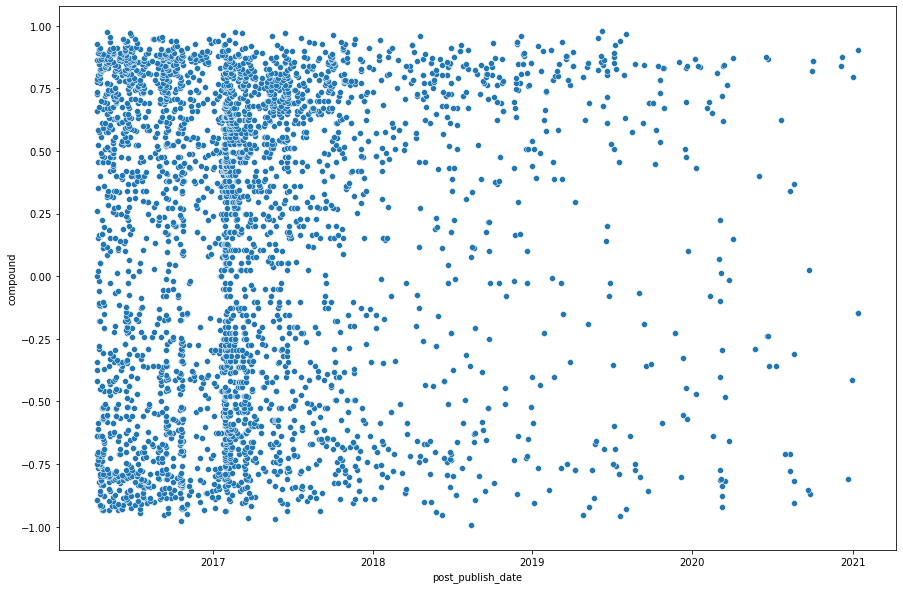

In [33]:
plt.figure(figsize=(15,10))

sns.scatterplot(data = df_refugees, x = "post_publish_date", y = "compound")

In [153]:
#finding co-occuring hashtags with "refugees"

hashtags = df['hashtags'].tolist()
pattern = re.compile(r'(.*),(refugees)',re.IGNORECASE)
newlist = list(filter(pattern.match, hashtags))  
print(newlist[:10]) 

['Tunisia,migrants,refugees', 'youth,refugees,education,Greece', 'Israel,refugeestatus', 'Belgrade,refugees', 'Belgrade,refugees', 'Greece,refugees,EU', 'Belgrade,refugees', 'Remain,RefugeesWelcome,BrexitSpeech,RefugeeCrisis,VoteLeave,Brexit', 'Kelebia,Horgos,refugees,Rendörseg,Hungary', 'neveragain,refugees,nevetforget']


In [154]:
#making the hashtags lowercase and separating them

foo = []
for item in newlist1:
    foo.append(item.lower().split(','))
      
flat_list = [item for sublist in foo for item in sublist]
print(flat_list[:10])

['tunisia', 'migrants', 'youtheducation', 'greece', 'israel', 'refugeestatus', 'belgrade', 'belgrade', 'greeceeu', 'belgrade']


In [155]:
#turn into pandas dataframe for generating wordcloud

cloud = pd.DataFrame(flat_list,columns=['Co-occuring'])
cloud.head()

,Co-occuring
0,tunisia
1,migrants
2,youtheducation
3,greece
4,israel


In [156]:
#removing any remaining refugees hashtag

cloud =cloud[cloud["Co-occuring"] != "refugees"]

In [157]:
#create wordcloud

text = " ".join(review for review in cloud['Co-occuring'].astype(str))
print ("There are {} hashtags in the combination with #refugees in the dataset".format(len(text)))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)


There are 289161 hashtags in the combination with #refugees in the dataset


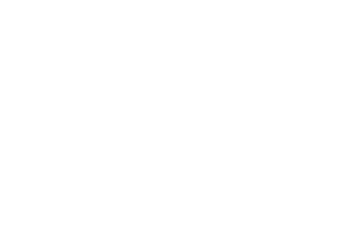

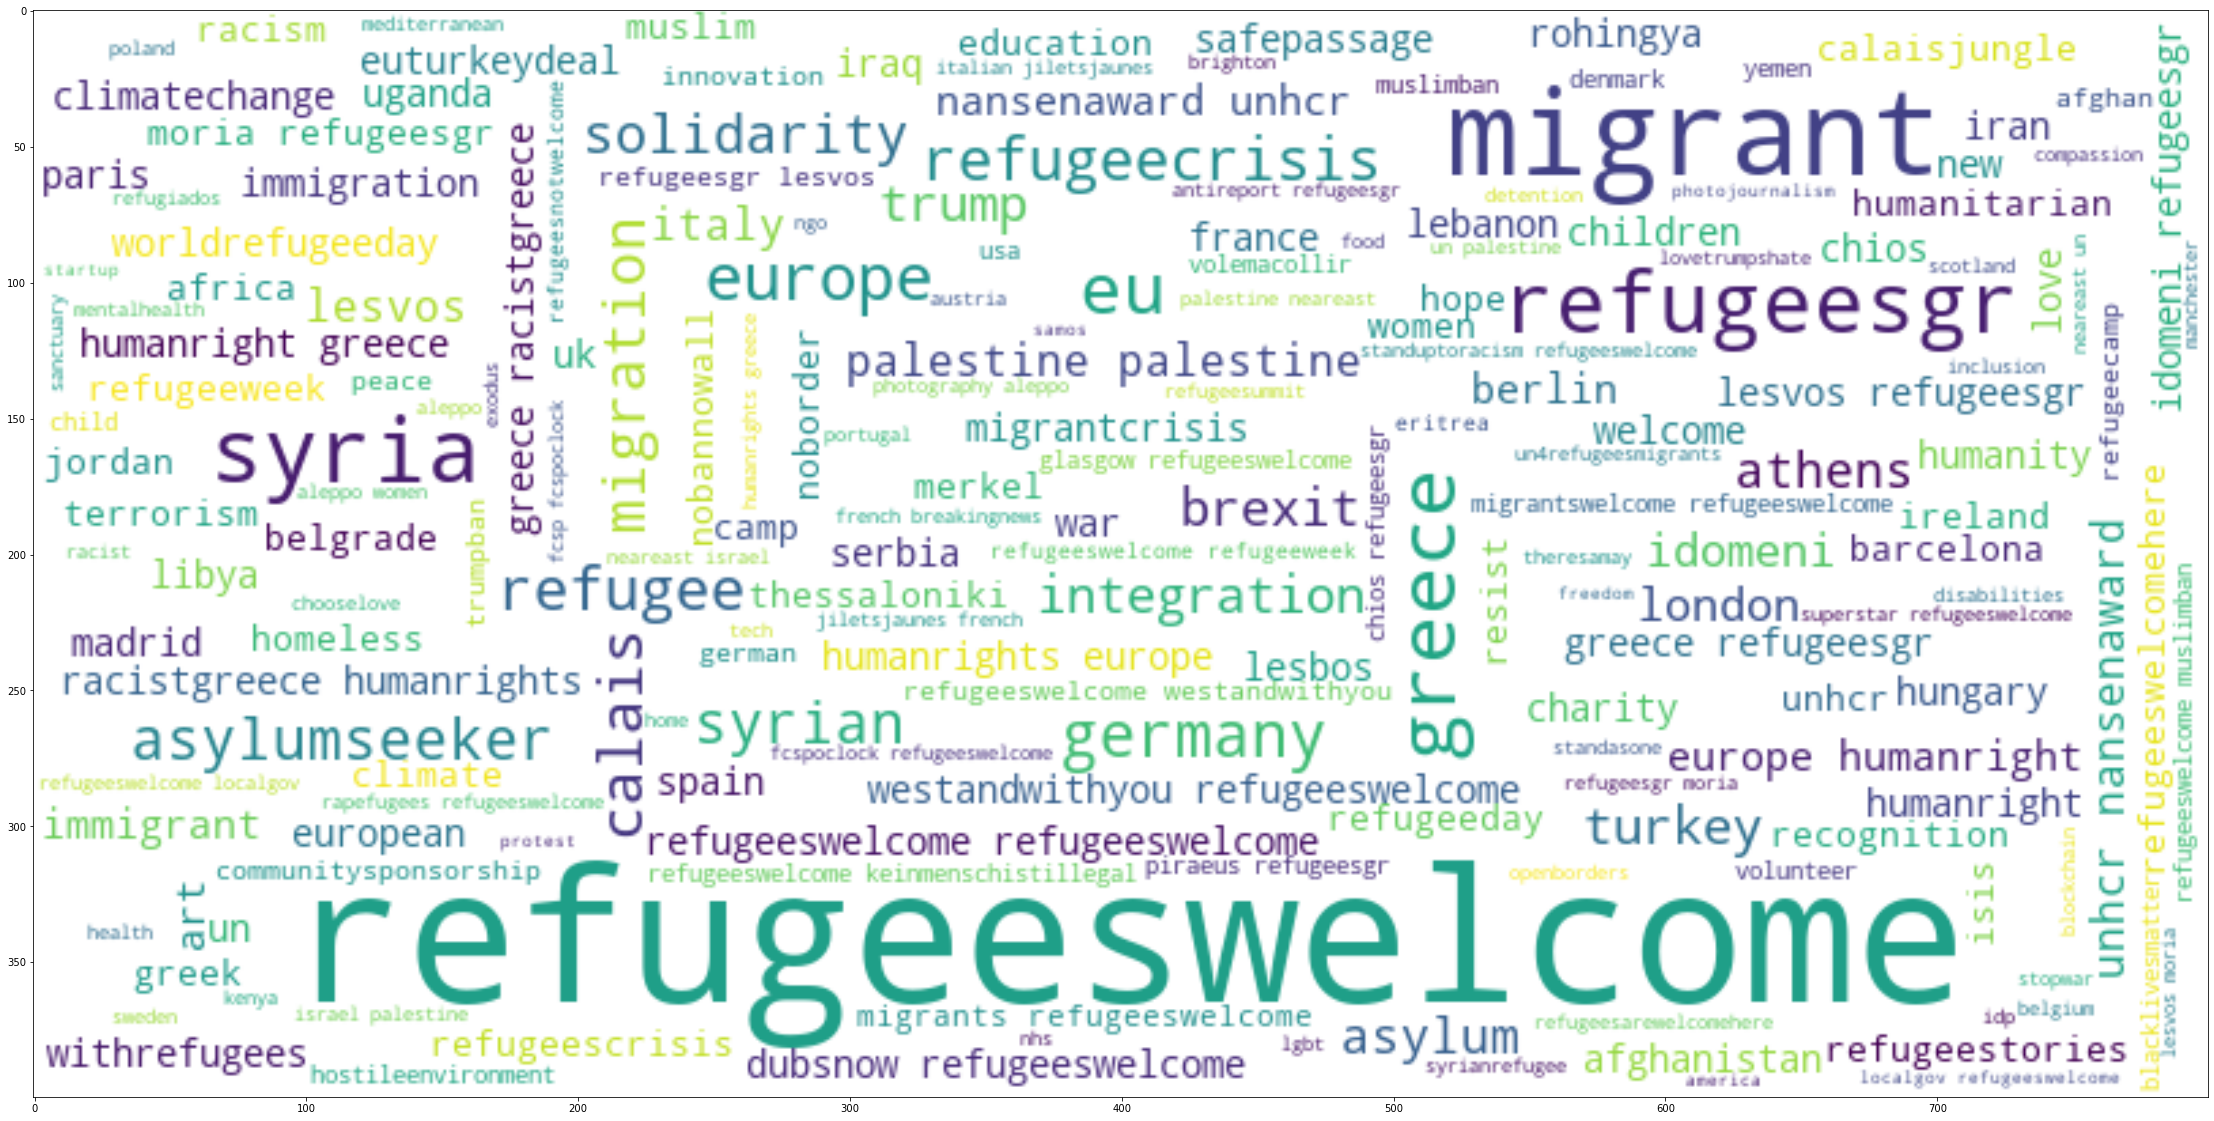

In [158]:
#show wordcloud

plt.axis("off")
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [159]:
#counting co-occuring 

refugee_cloud = Counter()
cloud['Co-occuring'].str.split(',').apply(refugee_cloud.update)
print(refugee_cloud.most_common(10))


[('refugeeswelcome', 2464), ('migrants', 581), ('refugeesgr', 531), ('greece', 350), ('syria', 305), ('europe', 261), ('humanrights', 184), ('eu', 160), ('lesvos', 144), ('unhcr', 137)]


In [25]:
#preparing for typicality calculation

df = df.set_index("post_publish_date")
df.head()

,long,lat,hashtags,post_body,emoji
post_publish_date,,,,,
2017-01-18 12:17:35,-2.115866,53.073712,"Brexit,PMQs,immigration",""".@theresa_may: '""We can still have EU workers...",
2017-01-18 12:19:19,14.380054,35.934249,"EU2017MT,migration",Throwing more money will not solve #migration ...,
2017-01-18 12:27:15,9.818380,46.764999,"wef17,TeamRefugees",Syrian refugee @YusraMardini speaking at a #we...,
2017-01-18 12:34:27,20.834226,39.655955,Refugee,#Refugee kids from the accommodation site of V...,
2017-01-18 13:07:08,4.577031,52.294800,"Tunisia,migrants,refugees",I'm afraid @CroissantRouge volunteers in #Tuni...,


In [26]:
#selecting data for 2016 (sub-setting the data)

refugee_2016 = df.loc["2016-01-01":"2016-12-31"]

<ipython-input-26-e5098baa69b2>:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  refugee_2016 = df.loc["2016-01-01":"2016-12-31"]


In [27]:
#calculating total relative frequency

total_hashtags = sum(results.values())

rel_frequency_total = results["refugees"]/total_hashtags
rel_frequency_total

0.07049316591711026

In [28]:
#counting refugees for 2016

results_2016 = Counter()
refugee_2016['hashtags'].str.lower().str.split(',').apply(results_2016.update)
print(results_2016.most_common(5))

[('refugees', 5047), ('refugeeswelcome', 2858), ('immigration', 1713), ('migration', 1711), ('refugeecrisis', 1513)]


In [29]:
rel_frequency_2016 = results_2016['refugees']/sum(results_2016.values())
rel_frequency_2016

0.08008949965882223

In [30]:
typicality_refugees_2016 = (rel_frequency_2016-rel_frequency_total)/rel_frequency_2016
typicality_refugees_2016*100

11.982012351921203